## A look at the Covid-19 pandemic in the Spanish "Comunidades Autonomas"

---
Last updated: 05/07/2020

Within the AISaturdays 2020 programme in Alicante, I have developed this notebook to conduct analysis and predictive work over the available Spanish CCAA covid-19 disaggregated data. 

Note only the following source data variables are available:

- Daily number of new confirmed cases
- Daily number of new deaths
- Average temperature (this is not used in this notebook)

Specifically I will do:

- data processing, most notably combining Ceuta & Melilla into one CCAA, leaving a total of 18 CCAAs to work with for the rest of the notebook, and calculating mortality as deaths divided by confirmed cases.
- a comparative analysis of the number of covid-19 cases and deaths across these CCAAs
- multi-step predictions of future Covid-19 confirmed cases and deaths with LSTM recurrent neural networks  

### Data load and pre-process

In [1]:
# Usual library imports.... more later 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates

mpl.rcdefaults()
plt.style.use('seaborn-whitegrid')

# Set precision to two decimals
pd.set_option("display.precision", 2)

# Define date format for charts like Apr 16 or Mar 8
my_date_fmt = mdates.DateFormatter('%b %e')

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
!ls ../input

covid19-cases-in-spain-by-ccaa-26042020


In [3]:
# Data loading
path = '../input/covid19-cases-in-spain-by-ccaa-26042020/'
file = 'serie_historica_acumulados_dv_05072020.csv'
df = pd.read_csv(path + file,  sep=',')

# Convert FECHA column to datetime format and set it as index
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d')
df.set_index('FECHA', inplace=True)

# Drop TMED column
df.drop(columns='TMED', inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2983 entries, 2020-01-31 to 2020-07-05
Data columns (total 3 columns):
CCAA          2983 non-null object
CASOS         2983 non-null int64
FALLECIDOS    2983 non-null int64
dtypes: int64(2), object(1)
memory usage: 93.2+ KB


In [5]:
df[['CASOS', 'FALLECIDOS']].sum()

CASOS         273655
FALLECIDOS     28187
dtype: int64

In [6]:
df

,CCAA,CASOS,FALLECIDOS
FECHA,,,
2020-01-31,Andalucia,0,0
2020-01-31,Aragon,0,0
2020-01-31,Asturias,0,0
2020-01-31,Baleares,0,0
2020-01-31,Canarias,0,0
...,...,...,...
2020-07-05,Navarra,1,0
2020-07-05,Pais Vasco,2,0
2020-07-05,La Rioja,0,0


### Split data by Comunidad Autonoma

In [7]:
# Create list of CCAA names
names_CCAA = df['CCAA'].unique()
print(len(names_CCAA), names_CCAA)

19 ['Andalucia' 'Aragon' 'Asturias' 'Baleares' 'Canarias' 'Cantabria'
 'Castilla y Leon' 'Castilla La Mancha' 'Catalunya' 'C. Valenciana'
 'Extremadura' 'Galicia' 'Madrid' 'Murcia' 'Navarra' 'Pais Vasco'
 'La Rioja' 'Ceuta' 'Melilla']


There are 19 administrative regions in Spain, the so called Comunidades Autonomas. 

For practical purposes I will consolidate the data for Ceuta (CE) and Melilla (ML), the two small towns in the North of Africa, into a single group (Ceuta & Melilla). For the rest of the notebook, I will work with 18 CCAAs.

For those who do not know much about this part of Earth geography, here goes a "zoom-in" map.

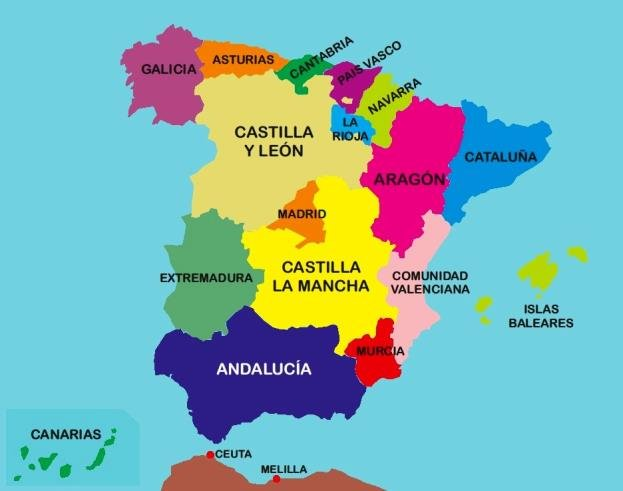


In [8]:
# Redefine CCAA names
names_CCAA = sorted({'Andalucia', 'Aragon', 'Asturias', 'Cantabria', 'Ceuta y Melilla', 'Castilla y Leon',
                     'Castilla La Mancha', 'Canarias', 'Catalunya', 'Extremadura', 'Galicia',  'Baleares', 'Murcia', 'Madrid',
                     'Navarra', 'Pais Vasco', 'La Rioja', 'C. Valenciana'})
names_CCAA

['Andalucia',
 'Aragon',
 'Asturias',
 'Baleares',
 'C. Valenciana',
 'Canarias',
 'Cantabria',
 'Castilla La Mancha',
 'Castilla y Leon',
 'Catalunya',
 'Ceuta y Melilla',
 'Extremadura',
 'Galicia',
 'La Rioja',
 'Madrid',
 'Murcia',
 'Navarra',
 'Pais Vasco']

In [9]:
# Create a dictionary of dataframes (one for each CCAA, remember with Ceuta and Melilla combined and calculate mortality)
array_df_CCAA = {}

for x in names_CCAA:
  if x == 'Ceuta y Melilla':
    array_df_CCAA[x] = pd.DataFrame(df[(df['CCAA'] == 'Ceuta') | (df['CCAA'] == 'Melilla')].groupby('FECHA').sum())
  else:
    array_df_CCAA[x] = pd.DataFrame(df[df['CCAA'] == x])
     # Drop CCAA column
    array_df_CCAA[x].drop('CCAA', axis=1, inplace=True)

for  x in names_CCAA:
    # Calculate mortality for each CCAA and store in new column
    array_df_CCAA[x]['MORTALITY'] = array_df_CCAA[x]['FALLECIDOS'].cumsum()/array_df_CCAA[x]['CASOS'].cumsum()
    # Fill nulls with 0
    array_df_CCAA[x].fillna(value=0, inplace=True)
       
array_df_CCAA

{'Andalucia':             CASOS  FALLECIDOS  MORTALITY
 FECHA                                   
 2020-01-31      0           0       0.00
 2020-02-01      2           0       0.00
 2020-02-02      2           0       0.00
 2020-02-03      1           0       0.00
 2020-02-04      1           0       0.00
 ...           ...         ...        ...
 2020-07-01      8           0       0.08
 2020-07-02      8           0       0.08
 2020-07-03      3           0       0.08
 2020-07-04      2           0       0.08
 2020-07-05      0           0       0.08
 
 [157 rows x 3 columns],
 'Aragon':             CASOS  FALLECIDOS  MORTALITY
 FECHA                                   
 2020-01-31      0           0       0.00
 2020-02-01      0           0       0.00
 2020-02-02      0           0       0.00
 2020-02-03      0           0       0.00
 2020-02-04      0           0       0.00
 ...           ...         ...        ...
 2020-07-01     10           0       0.13
 2020-07-02      9        

## Charts of confirmed cases, deaths and mortality

---

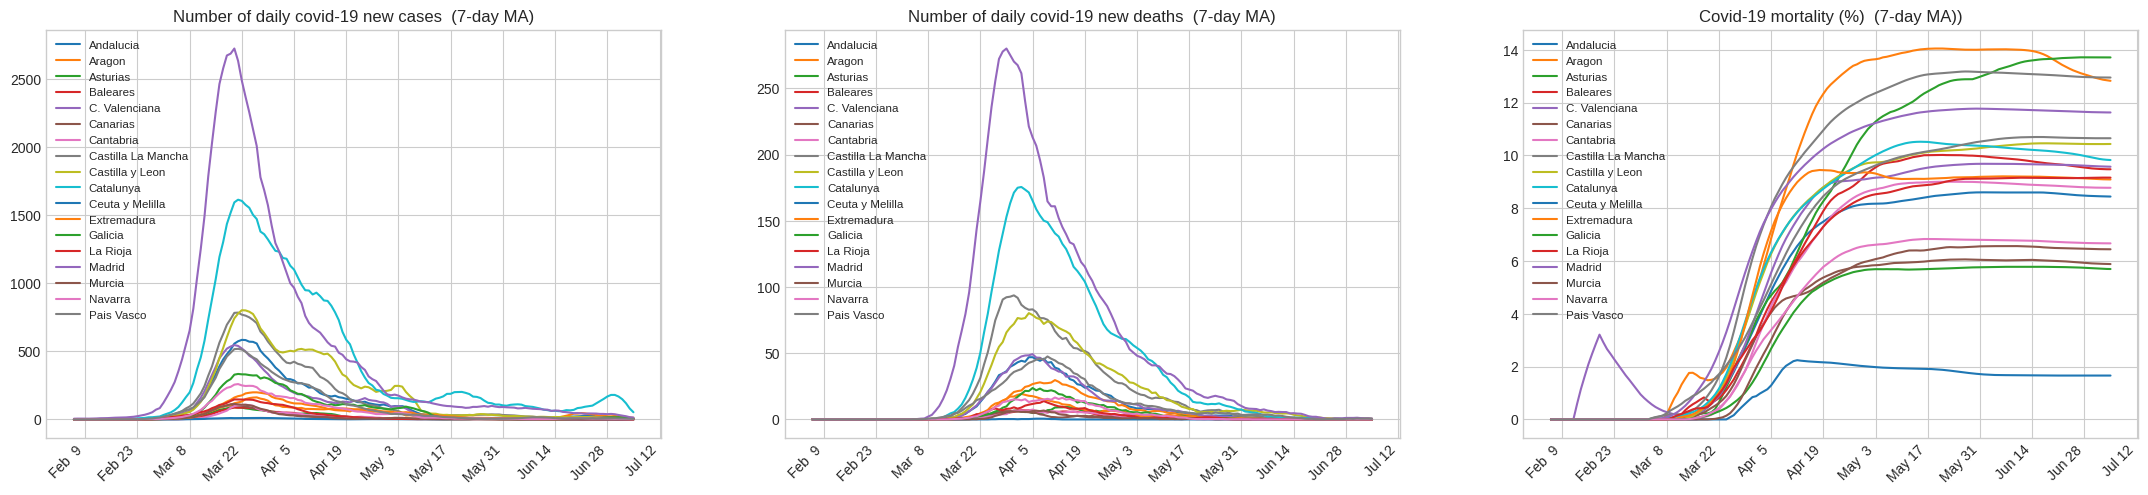

In [10]:
fig, ax = plt.subplots(1,3, figsize=(27,6))

# Plot number of confirmed cases by CCAA
ax[0].set_title('Number of daily covid-19 new cases  (7-day MA)', fontsize='large')
ax[0].xaxis.set_major_formatter(my_date_fmt)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(14))

for x in names_CCAA:
    dfx = array_df_CCAA[x]
    ax[0].plot(dfx.index, dfx['CASOS'].rolling(window=7).mean(), linewidth=1.5, label=x)
    
ax[0].legend(loc='upper left', fontsize='small')

# Plot number of deaths by CCAA
ax[1].set_title('Number of daily covid-19 new deaths  (7-day MA)', fontsize='large')
ax[1].xaxis.set_major_formatter(my_date_fmt)
ax[1].xaxis.set_major_locator(plt.MultipleLocator(14))
   
for x in names_CCAA:
    dfx = array_df_CCAA[x]
    ax[1].plot(dfx.index, dfx['FALLECIDOS'].rolling(window=7).mean(), linewidth=1.5, label=x)
   
ax[1].legend(loc='upper left', fontsize='small')

# Plot mortality by CCAA
ax[2].set_title('Covid-19 mortality (%)  (7-day MA))', fontsize='large')
ax[2].xaxis.set_major_formatter(my_date_fmt)
ax[2].xaxis.set_major_locator(plt.MultipleLocator(14))
   
for x in names_CCAA:
    dfx = array_df_CCAA[x]
    ax[2].plot(dfx.index, 100 * dfx['MORTALITY'].rolling(window=7).mean(), linewidth=1.5, label=x)
   
ax[2].legend(loc='upper left', fontsize='small')

fig.autofmt_xdate(rotation=45, ha='right')
plt.show()

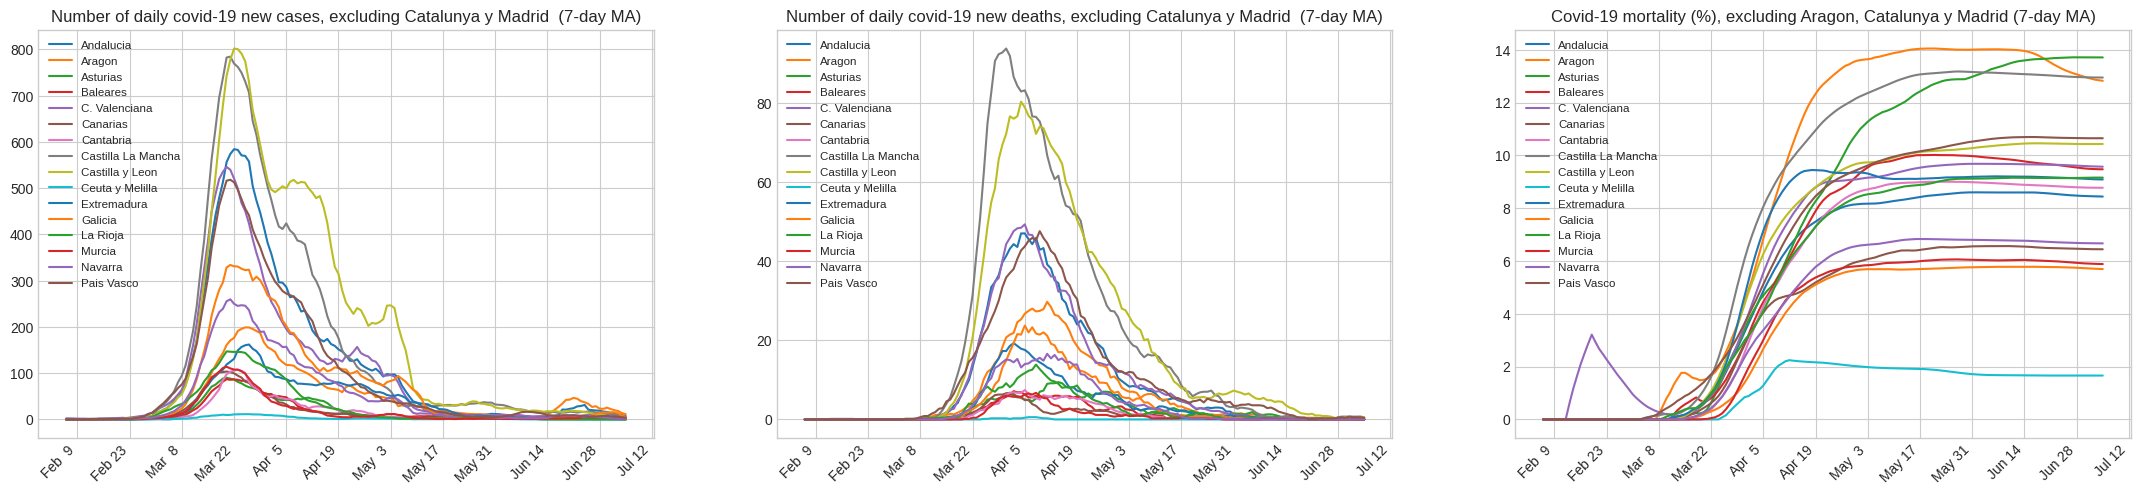

In [11]:
# Now the same excluding Madrid and Catalunya (like zooming in)
fig, ax = plt.subplots(1,3, figsize=(27,6))

# Plot number of confirmed cases by CCAA
ax[0].set_title('Number of daily covid-19 new cases, excluding Catalunya y Madrid  (7-day MA)', fontsize='large')
ax[0].xaxis.set_major_formatter(my_date_fmt)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(14))

for x in names_CCAA:
    if (x != 'Madrid') and (x !='Catalunya'):
        dfx = array_df_CCAA[x]
        ax[0].plot(dfx.index, dfx['CASOS'].rolling(window=7).mean(), linewidth=1.5, label=x)
    
ax[0].legend(loc='upper left', fontsize='small')

# Plot number of deaths by CCAA
ax[1].set_title('Number of daily covid-19 new deaths, excluding Catalunya y Madrid  (7-day MA)', fontsize='large')
ax[1].xaxis.set_major_formatter(my_date_fmt)
ax[1].xaxis.set_major_locator(plt.MultipleLocator(14))
   
for x in names_CCAA:
    if (x != 'Madrid') and (x !='Catalunya'):
        dfx = array_df_CCAA[x]
        ax[1].plot(dfx.index, dfx['FALLECIDOS'].rolling(window=7).mean(), linewidth=1.5, label=x)
   
ax[1].legend(loc='upper left', fontsize='small')

# Plot mortality by CCAA
ax[2].set_title('Covid-19 mortality (%), excluding Aragon, Catalunya y Madrid (7-day MA)', fontsize='large')
ax[2].xaxis.set_major_formatter(my_date_fmt)
ax[2].xaxis.set_major_locator(plt.MultipleLocator(14))
   
for x in names_CCAA:
    if (x != 'Madrid') and (x !='Catalunya'): # and (x !='AR'):
        dfx = array_df_CCAA[x]
        ax[2].plot(dfx.index, 100 * dfx['MORTALITY'].rolling(window=7).mean(), linewidth=1.5, label=x)
   
ax[2].legend(loc='upper left', fontsize='small')

fig.autofmt_xdate(rotation=45, ha='right')
plt.show()

In [12]:
# Create small dataframe with total number of confirmed cases and deaths
df_cum = df.groupby('CCAA').sum()
df_cum.T

CCAA,Andalucia,Aragon,Asturias,Baleares,C. Valenciana,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Catalunya,Ceuta,Extremadura,Galicia,La Rioja,Madrid,Melilla,Murcia,Navarra,Pais Vasco
CASOS,16889,7077,2436,2364,14955,2514,2359,22435,26719,57762,222,5701,10873,3996,72137,139,2499,7921,14657
FALLECIDOS,1425,906,334,224,1431,162,207,2905,2789,5671,4,518,619,366,8388,2,147,528,1561


In [13]:
# Combine CE and ML
df_cum.loc['Ceuta'] += df_cum.loc['Melilla']
df_cum.drop(['Melilla'], inplace=True)
# Rename 'CE' as 'CEML'
df_cum.rename(index={'Ceuta':'Ceuta y Melilla'},inplace=True)
df_cum.T

CCAA,Andalucia,Aragon,Asturias,Baleares,C. Valenciana,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Catalunya,Ceuta y Melilla,Extremadura,Galicia,La Rioja,Madrid,Murcia,Navarra,Pais Vasco
CASOS,16889,7077,2436,2364,14955,2514,2359,22435,26719,57762,361,5701,10873,3996,72137,2499,7921,14657
FALLECIDOS,1425,906,334,224,1431,162,207,2905,2789,5671,6,518,619,366,8388,147,528,1561


The data displayed corresponds to the total number of confirmed cases (CASOS) and deaths (FALLECIDOS).

In [14]:
df_cum_cases = df_cum.CASOS.copy()
df_cum_cases.sort_values(ascending=False, inplace=True)

In [15]:
df_cum_deaths = df_cum.FALLECIDOS.copy()
df_cum_deaths.sort_values(ascending=False, inplace=True)

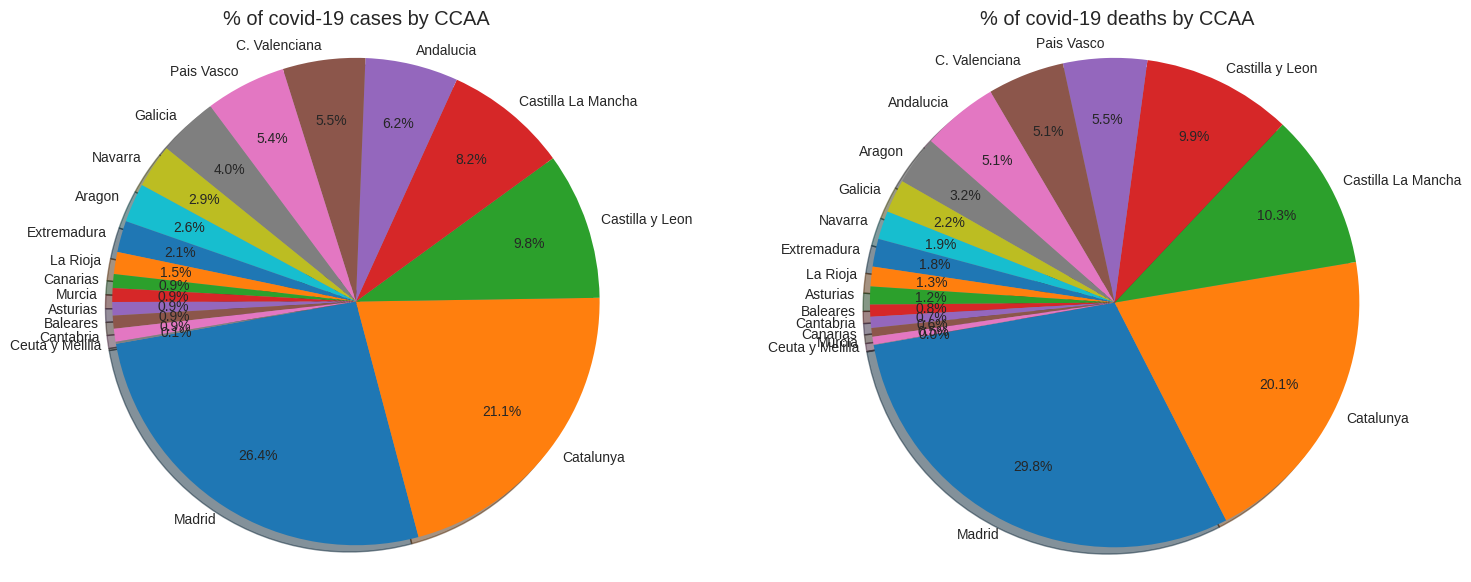

In [16]:
# Pie charts with % contribution from each CCAA
fig, ax = plt.subplots(1,2, figsize=(18,7))

ax[0].set_title('% of covid-19 cases by CCAA', fontsize='x-large')
ax[1].set_title('% of covid-19 deaths by CCAA', fontsize='x-large')

ax[0].pie(df_cum_cases.values, labels=df_cum_cases.index, autopct='%1.1f%%', startangle=190, pctdistance=0.75, labeldistance=1.06, shadow=True)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].pie(df_cum_deaths.values, labels=df_cum_deaths.index, autopct='%1.1f%%', startangle=190, pctdistance=0.75, labeldistance=1.06, shadow=True)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.savefig("fig5.pdf")
plt.show()

Madrid and Catalunya are the most hardly hit regions of Spain. Castilla Leon and Castilla La Mancha, geographically close to Madrid, follow.



## Process data for neural network training
---

### Separate cases and deaths series

In [17]:
array_df_CCAA

{'Andalucia':             CASOS  FALLECIDOS  MORTALITY
 FECHA                                   
 2020-01-31      0           0       0.00
 2020-02-01      2           0       0.00
 2020-02-02      2           0       0.00
 2020-02-03      1           0       0.00
 2020-02-04      1           0       0.00
 ...           ...         ...        ...
 2020-07-01      8           0       0.08
 2020-07-02      8           0       0.08
 2020-07-03      3           0       0.08
 2020-07-04      2           0       0.08
 2020-07-05      0           0       0.08
 
 [157 rows x 3 columns],
 'Aragon':             CASOS  FALLECIDOS  MORTALITY
 FECHA                                   
 2020-01-31      0           0       0.00
 2020-02-01      0           0       0.00
 2020-02-02      0           0       0.00
 2020-02-03      0           0       0.00
 2020-02-04      0           0       0.00
 ...           ...         ...        ...
 2020-07-01     10           0       0.13
 2020-07-02      9        

In [18]:
# Create empty dataframes for CASES, DEATHS and MORTALITY
df_CASES = pd.DataFrame(index=df.index.unique())
df_DEATHS = pd.DataFrame(index=df.index.unique())

# Populate dataframes
i = 0
for x in names_CCAA:
    df_CASES.insert(loc=i, column=x, value=array_df_CCAA[x].CASOS.values) 
    df_DEATHS.insert(loc=i, column=x, value=array_df_CCAA[x].FALLECIDOS.values)     
    i = i + 1

In [19]:
df_CASES

,Andalucia,Aragon,Asturias,Baleares,C. Valenciana,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Catalunya,Ceuta y Melilla,Extremadura,Galicia,La Rioja,Madrid,Murcia,Navarra,Pais Vasco
FECHA,,,,,,,,,,,,,,,,,,
2020-01-31,0,0,0,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0
2020-02-01,2,0,0,0,1,0,0,0,0,7,0,0,0,0,9,0,0,0
2020-02-02,2,0,0,0,0,1,0,0,0,1,0,2,1,0,6,0,0,0
2020-02-03,1,0,0,0,5,0,0,0,1,2,0,0,1,1,7,0,0,0
2020-02-04,1,0,0,0,1,1,0,0,1,4,0,0,1,0,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01,8,10,1,0,7,0,0,7,1,59,0,3,10,0,14,3,1,3
2020-07-02,8,9,0,0,6,1,0,2,2,36,0,0,2,0,7,1,1,1
2020-07-03,3,11,0,0,2,0,0,1,0,2,0,1,5,0,5,0,3,4


In [20]:
df_DEATHS

,Andalucia,Aragon,Asturias,Baleares,C. Valenciana,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Catalunya,Ceuta y Melilla,Extremadura,Galicia,La Rioja,Madrid,Murcia,Navarra,Pais Vasco
FECHA,,,,,,,,,,,,,,,,,,
2020-01-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2
2020-07-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-07-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Build a RNN and make predictions of confirmed cases and deaths

---
### How does the neural network function?

The network works in such way that it will predict the value of a variable at a time t from the values at times t-1, t-2 .... t-TIME_STEPS. By retroffiting the predictions at time t, the RNN can predict also at time t+1. And so on for predictions at t+2, t+3 ... t+NBR_PREDICTIONS.

In order to get trained for the task, the RNN needs training data input in an specific format. 

- Data is presented to the RNN in sequences, where a sequence will consist of the values Y(t) to predict along with the values of variables X(t - 1), X(t - 2), X(t - TIME_STEP S).

- The RNN will be trained during a number of cycles (EPOCH). In each of these cycles, a batch of overlapping sequences (as defined by BATCH_SIZE) is introduced, and the RNN makes the corresponding prediction.

- The prediction is then compared to the actual value Y(t) and the parameters are adjusted to minimize the error (loss) throughout the neural network at the end of each EPOCHS .

So for instance, on the first step of the first EPOCH, if N_INPUTS=3 and BATCH_SIZE=4, we would be feeding the network with the following training batch:

y(t) x(t-1) x(t-2) x(t-3)

y(t-1) x(t-2) x(t-3) x(t-4)

y(t-2) x(t-3) x(t-4) x(t-5)

y(t-3) x(t-4) x(t-5) x(t-6)

The second step of the first EPOCHS would use a different batch to the above. And that would go on until exhausting all possible combinations of training inputs. And then the same thing again would happen for all EPOCHS, until utilizing all batches in the training set.

### Model parameters

In [21]:
# Model parameters

# Number of samples
NBR_SAMPLES = df_CASES.shape[0]

# Number of features Xi 
NBR_FEATURES = len(df_CASES.columns)

# Number of predictions (days)
NBR_PREDICTIONS = 56

# Size ot TRAIN and TEST samples
NBR_TRAIN_SAMPLES = NBR_SAMPLES - NBR_PREDICTIONS
NBR_TEST_SAMPLES = NBR_SAMPLES - NBR_TRAIN_SAMPLES

# Number of input steps [x(t-1), x(t-2), x(t-3)...] to predict an output y(t)
TIME_STEPS = 8

# Number of overlapping training sequences of TIME_STEPS
BATCH_SIZE = 16

# Number of training cycles
EPOCHS = 100

print('LSTM NEURAL NETWORK MODEL PARAMETERS')
print('------------------------------------')
print('NBR_SAMPLES: ', NBR_SAMPLES)
print('NBR_TRAIN_SAMPLES: ', NBR_TRAIN_SAMPLES)
print('NBR_TEST_SAMPLES: ', NBR_TEST_SAMPLES)
print()
print('TIME_STEPS:', TIME_STEPS)
print('NBR_FEATURES: ', NBR_FEATURES)
print('BATCH_SIZE: ', BATCH_SIZE)
print('EPOCHS: ', EPOCHS)

LSTM NEURAL NETWORK MODEL PARAMETERS
------------------------------------
NBR_SAMPLES:  157
NBR_TRAIN_SAMPLES:  101
NBR_TEST_SAMPLES:  56

TIME_STEPS: 8
NBR_FEATURES:  18
BATCH_SIZE:  16
EPOCHS:  100


Now I will split the dataset into train and test subsets, normalize them and prepare it for the neural network.

In [22]:
# Split dataset into test and train subsets
df_cases_train = df_CASES.iloc[0:NBR_TRAIN_SAMPLES, 0:NBR_FEATURES] 
df_cases_test = df_CASES.iloc[NBR_TRAIN_SAMPLES:, 0:NBR_FEATURES]
df_deaths_train = df_DEATHS.iloc[0:NBR_TRAIN_SAMPLES, 0:NBR_FEATURES] 
df_deaths_test = df_DEATHS.iloc[NBR_TRAIN_SAMPLES:, 0:NBR_FEATURES]

In [23]:
# Normalize test and train data (range: 0 - 1)
from sklearn.preprocessing import MinMaxScaler
# Normalize CASES data
sc1 = MinMaxScaler(feature_range = (0, 1))
sc1.fit(df_cases_train)
sc1_df_train = sc1.transform(df_cases_train)
sc1_df_test = sc1.transform(df_cases_test)
# Normalize DEATHS data
sc2 = MinMaxScaler(feature_range = (0, 1))
sc2.fit(df_deaths_train)
sc2_df_train = sc2.transform(df_deaths_train)
sc2_df_test = sc2.transform(df_deaths_test)

To train the RNN, data has to be input in batches of sequences of BATCH_SIZE x TIME_STEPS along with the knwon output data.

In [24]:
# Prepare training sequences: CASES data
X1_train = []
y1_train = []
for i in range(TIME_STEPS, NBR_TRAIN_SAMPLES):
    X1_train.append(sc1_df_train[i-TIME_STEPS:i, 0:NBR_FEATURES])
    y1_train.append(sc1_df_train[i, 0:NBR_FEATURES])
       
X1_train, y1_train = np.array(X1_train), np.array(y1_train)
X1_train = np.reshape(X1_train, (X1_train.shape[0], X1_train.shape[1], NBR_FEATURES))

# Prepare training sequences: DEATHS data
X2_train = []
y2_train = []
for i in range(TIME_STEPS, NBR_TRAIN_SAMPLES):
    X2_train.append(sc2_df_train[i-TIME_STEPS:i, 0:NBR_FEATURES])
    y2_train.append(sc2_df_train[i, 0:NBR_FEATURES])
       
X2_train, y2_train = np.array(X2_train), np.array(y2_train)
X2_train = np.reshape(X2_train, (X2_train.shape[0], X2_train.shape[1], NBR_FEATURES))

In [25]:
X1_train.shape # NBR_BATCHES x TIME_STEPS x NBR_FEATURES

(93, 8, 18)

In [26]:
y1_train.shape

(93, 18)

### Build, train and validate the neural networks

In [27]:
# Build the RNN, dropout helps prevent overfitting
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout 

# Initialize structure, 3 layers LSTM
RNN1 = Sequential()

# Build layers:
# 3 LSTM layers
# Dropout 25% in each LSTM layer
# Nbr Feaures output dense layers
RNN1.add(LSTM(units = 512, return_sequences = True, input_shape = (X1_train.shape[1], NBR_FEATURES)))
RNN1.add(Dropout(0.4))
RNN1.add(LSTM(units = 512, return_sequences=True))
RNN1.add(Dropout(0.3))
RNN1.add(LSTM(units = 256))
RNN1.add(Dropout(0.3))
RNN1.add(Dense(units = NBR_FEATURES, activation='relu'))

RNN1.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 512)            1087488   
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)               

In [28]:
# Initialize structure, 3 layers LSTM
RNN2 = Sequential()

# Build layers:
# 3 LSTM layers
# Dropout 25% in each LSTM layer
# Nbr Feaures output dense layers
RNN2.add(LSTM(units = 512, return_sequences = True, input_shape = (X2_train.shape[1], NBR_FEATURES)))
RNN2.add(Dropout(0.4))
RNN2.add(LSTM(units = 512, return_sequences=True))
RNN2.add(Dropout(0.3))
RNN2.add(LSTM(units = 256))
RNN2.add(Dropout(0.3))
RNN2.add(Dense(units = NBR_FEATURES, activation='relu'))

RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 8, 512)            1087488   
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)               

In [29]:
%%time
# Compile the RNN
RNN1.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Train the RNN
RNN1.fit(X1_train, y1_train, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/100
93/93 [==============================] - 2s 26ms/step - loss: 0.0659
Epoch 2/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 3/100
93/93 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 4/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 5/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 6/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 7/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 9/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 10/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 11/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 12/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 13/100
93/93 [================

In [30]:
%%time
# Compile the RNN
RNN2.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Train the RNN
RNN2.fit(X2_train, y2_train, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/100
93/93 [==============================] - 2s 18ms/step - loss: 0.0728
Epoch 2/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 3/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0334
Epoch 4/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 5/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 6/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 7/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 8/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 9/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 10/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 11/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 12/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 13/100
93/93 [================

In [31]:
# Use now the full dataframe to predict / evaluate the model
df1_full = df_CASES.iloc[:, 0:NBR_FEATURES]
df2_full = df_DEATHS.iloc[:, 0:NBR_FEATURES]

# Scale full dataset (use same scaler fitted with train data earlier)
df1_full = sc1.transform(df1_full)
df2_full = sc2.transform(df2_full)

X1_test = []
X2_test = []

for i in range(NBR_TRAIN_SAMPLES, NBR_SAMPLES):
    X1_test.append(df1_full[i-TIME_STEPS:i, 0:NBR_FEATURES])
    X2_test.append(df2_full[i-TIME_STEPS:i, 0:NBR_FEATURES])
    
X1_test = np.array(X1_test)
X1_test = np.reshape(X1_test, (X1_test.shape[0], X1_test.shape[1], NBR_FEATURES))

X2_test = np.array(X2_test)
X2_test = np.reshape(X2_test, (X2_test.shape[0], X2_test.shape[1], NBR_FEATURES))

# Make predctions
predicted_values_1 = RNN1.predict(X1_test)
predicted_values_1 = sc1.inverse_transform(predicted_values_1)
predicted_values_2 = RNN2.predict(X2_test)
predicted_values_2 = sc2.inverse_transform(predicted_values_2)

In [32]:
# Add columns with predictions
i = 0
for x in names_CCAA:
  df_cases_test[x + '_PREDICTED'] = predicted_values_1[:,i]
  df_deaths_test[x + '_PREDICTED'] = predicted_values_2[:,i]  
  i = i+1

### Plot the predictions and validation data

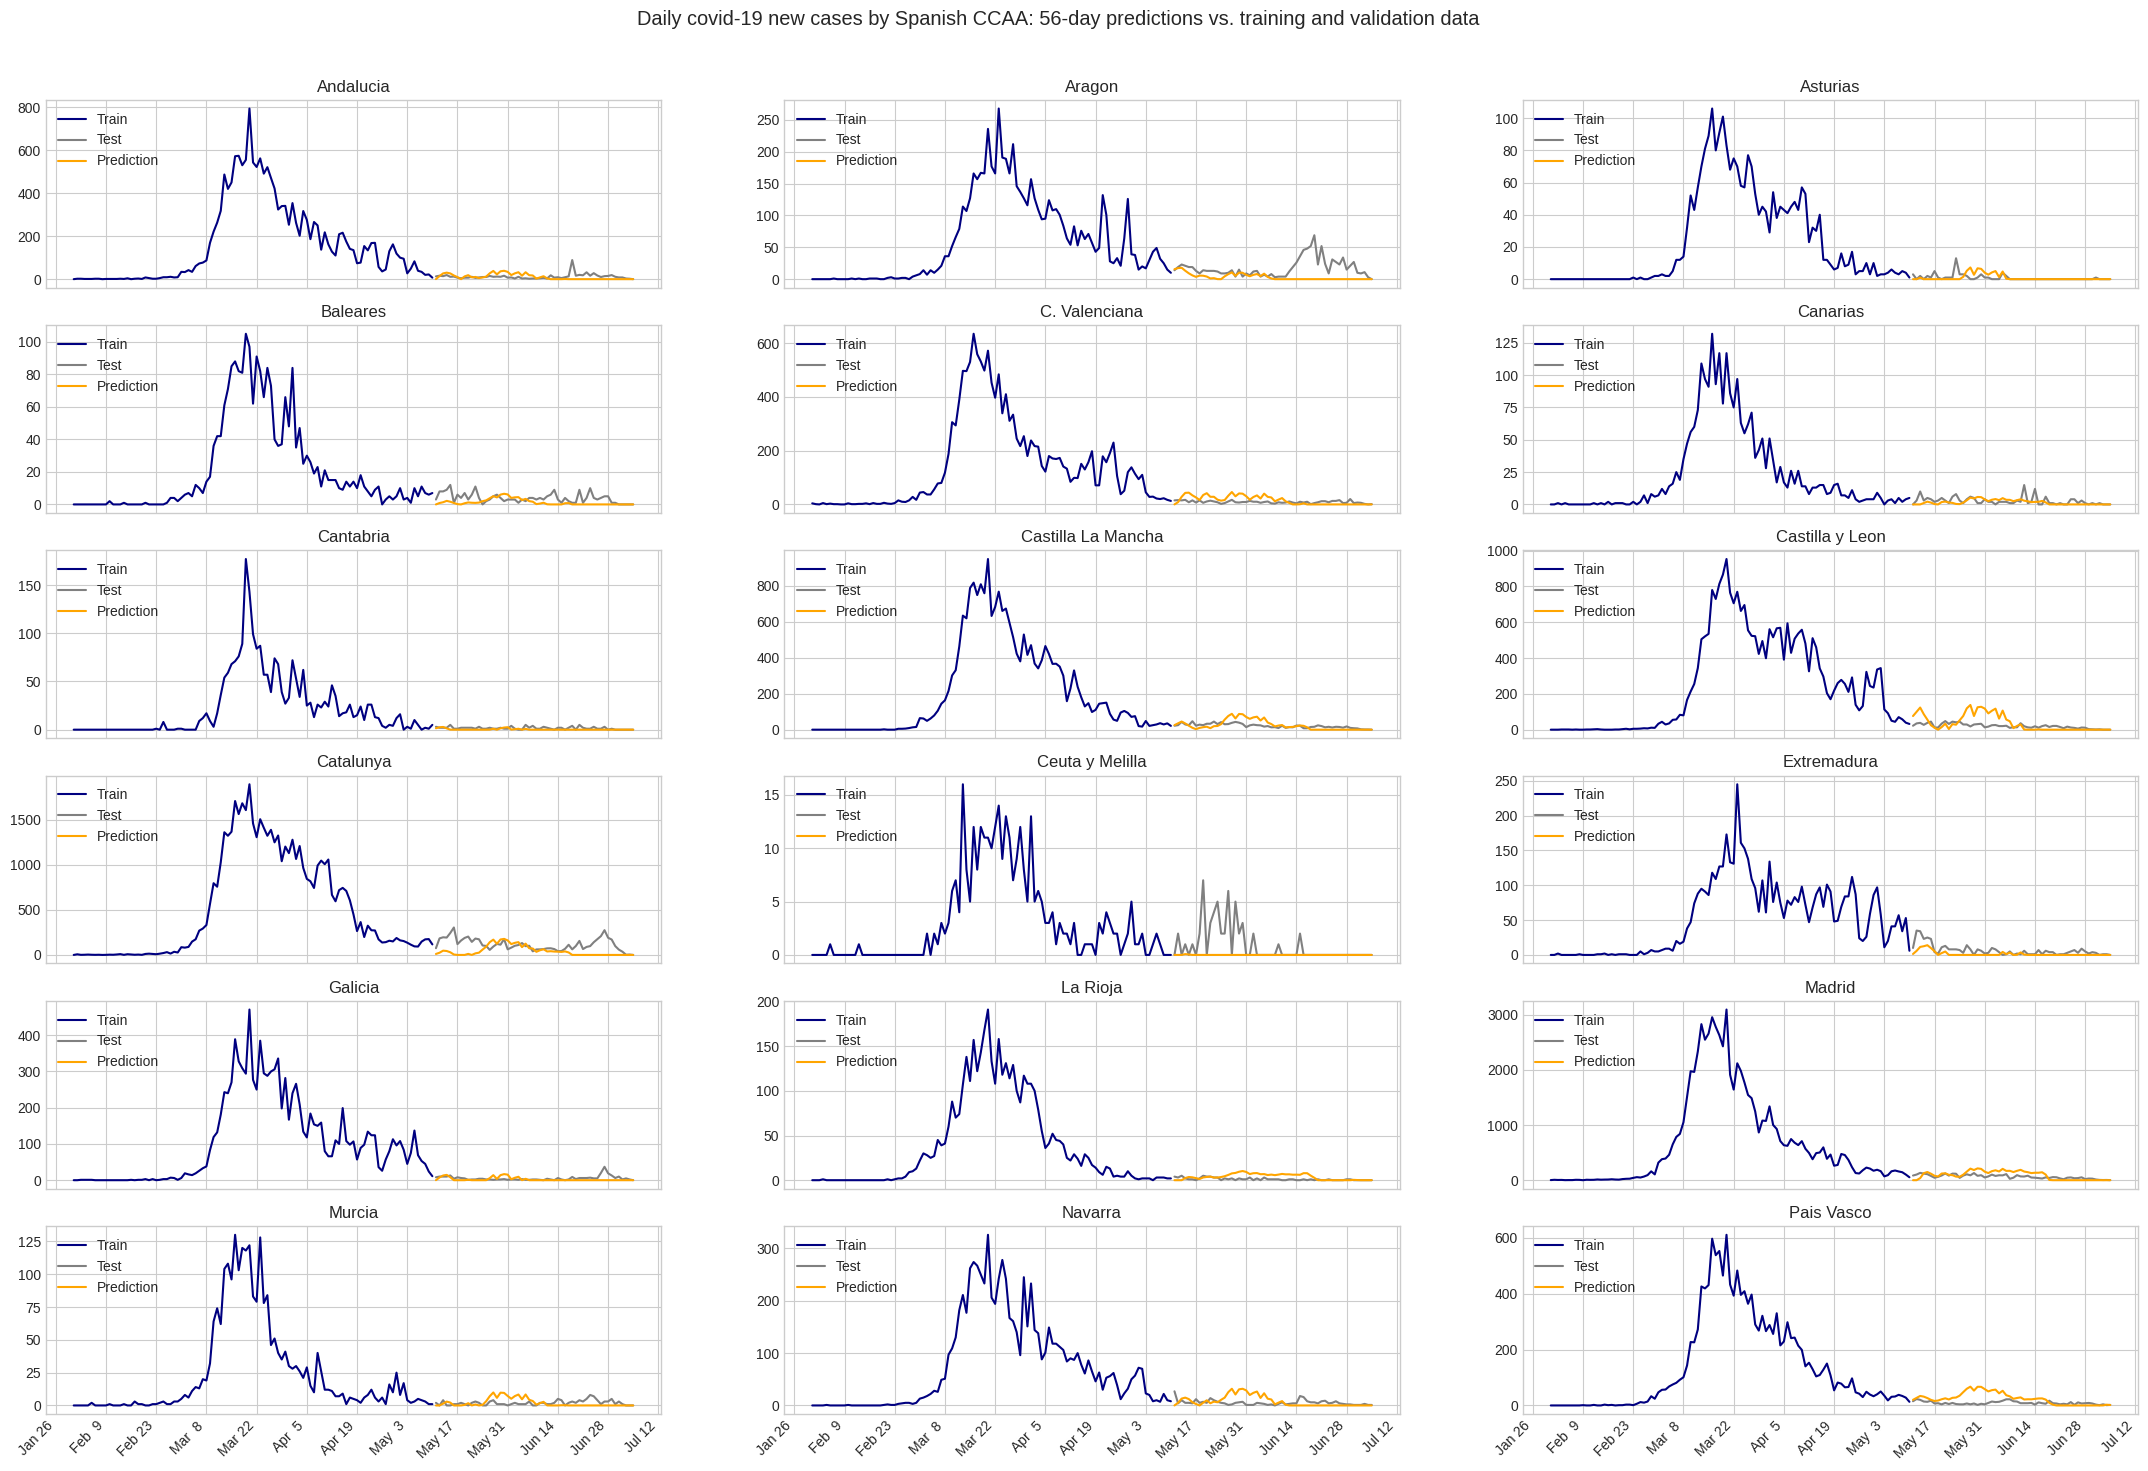

In [33]:
fig, ax = plt.subplots(6,3, figsize=(27,18))
fig.subplots_adjust(top=0.93)
i = 0
j = 0
for x in names_CCAA:
  ax[i,j].set_title(x, fontsize='large')
  ax[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax[i,j].xaxis.set_major_locator(plt.MultipleLocator(14))
  ax[i,j].plot(df_cases_train.index, df_cases_train[x], linewidth=1.5,color='navy', label='Train')
  ax[i,j].plot(df_cases_test.index, df_cases_test[x], linewidth=1.5, color='grey', label='Test')
  ax[i,j].plot(df_cases_test.index, df_cases_test[x + '_PREDICTED'], linewidth=1.5, color='orange', label='Prediction')
  ax[i,j].legend(loc='upper left', fontsize='medium')
  if j < 2:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig.suptitle('Daily covid-19 new cases by Spanish CCAA: ' + str(NBR_PREDICTIONS) + '-day predictions vs. training and validation data', fontsize='x-large')  
fig.autofmt_xdate(rotation=45, ha='right')
plt.show()

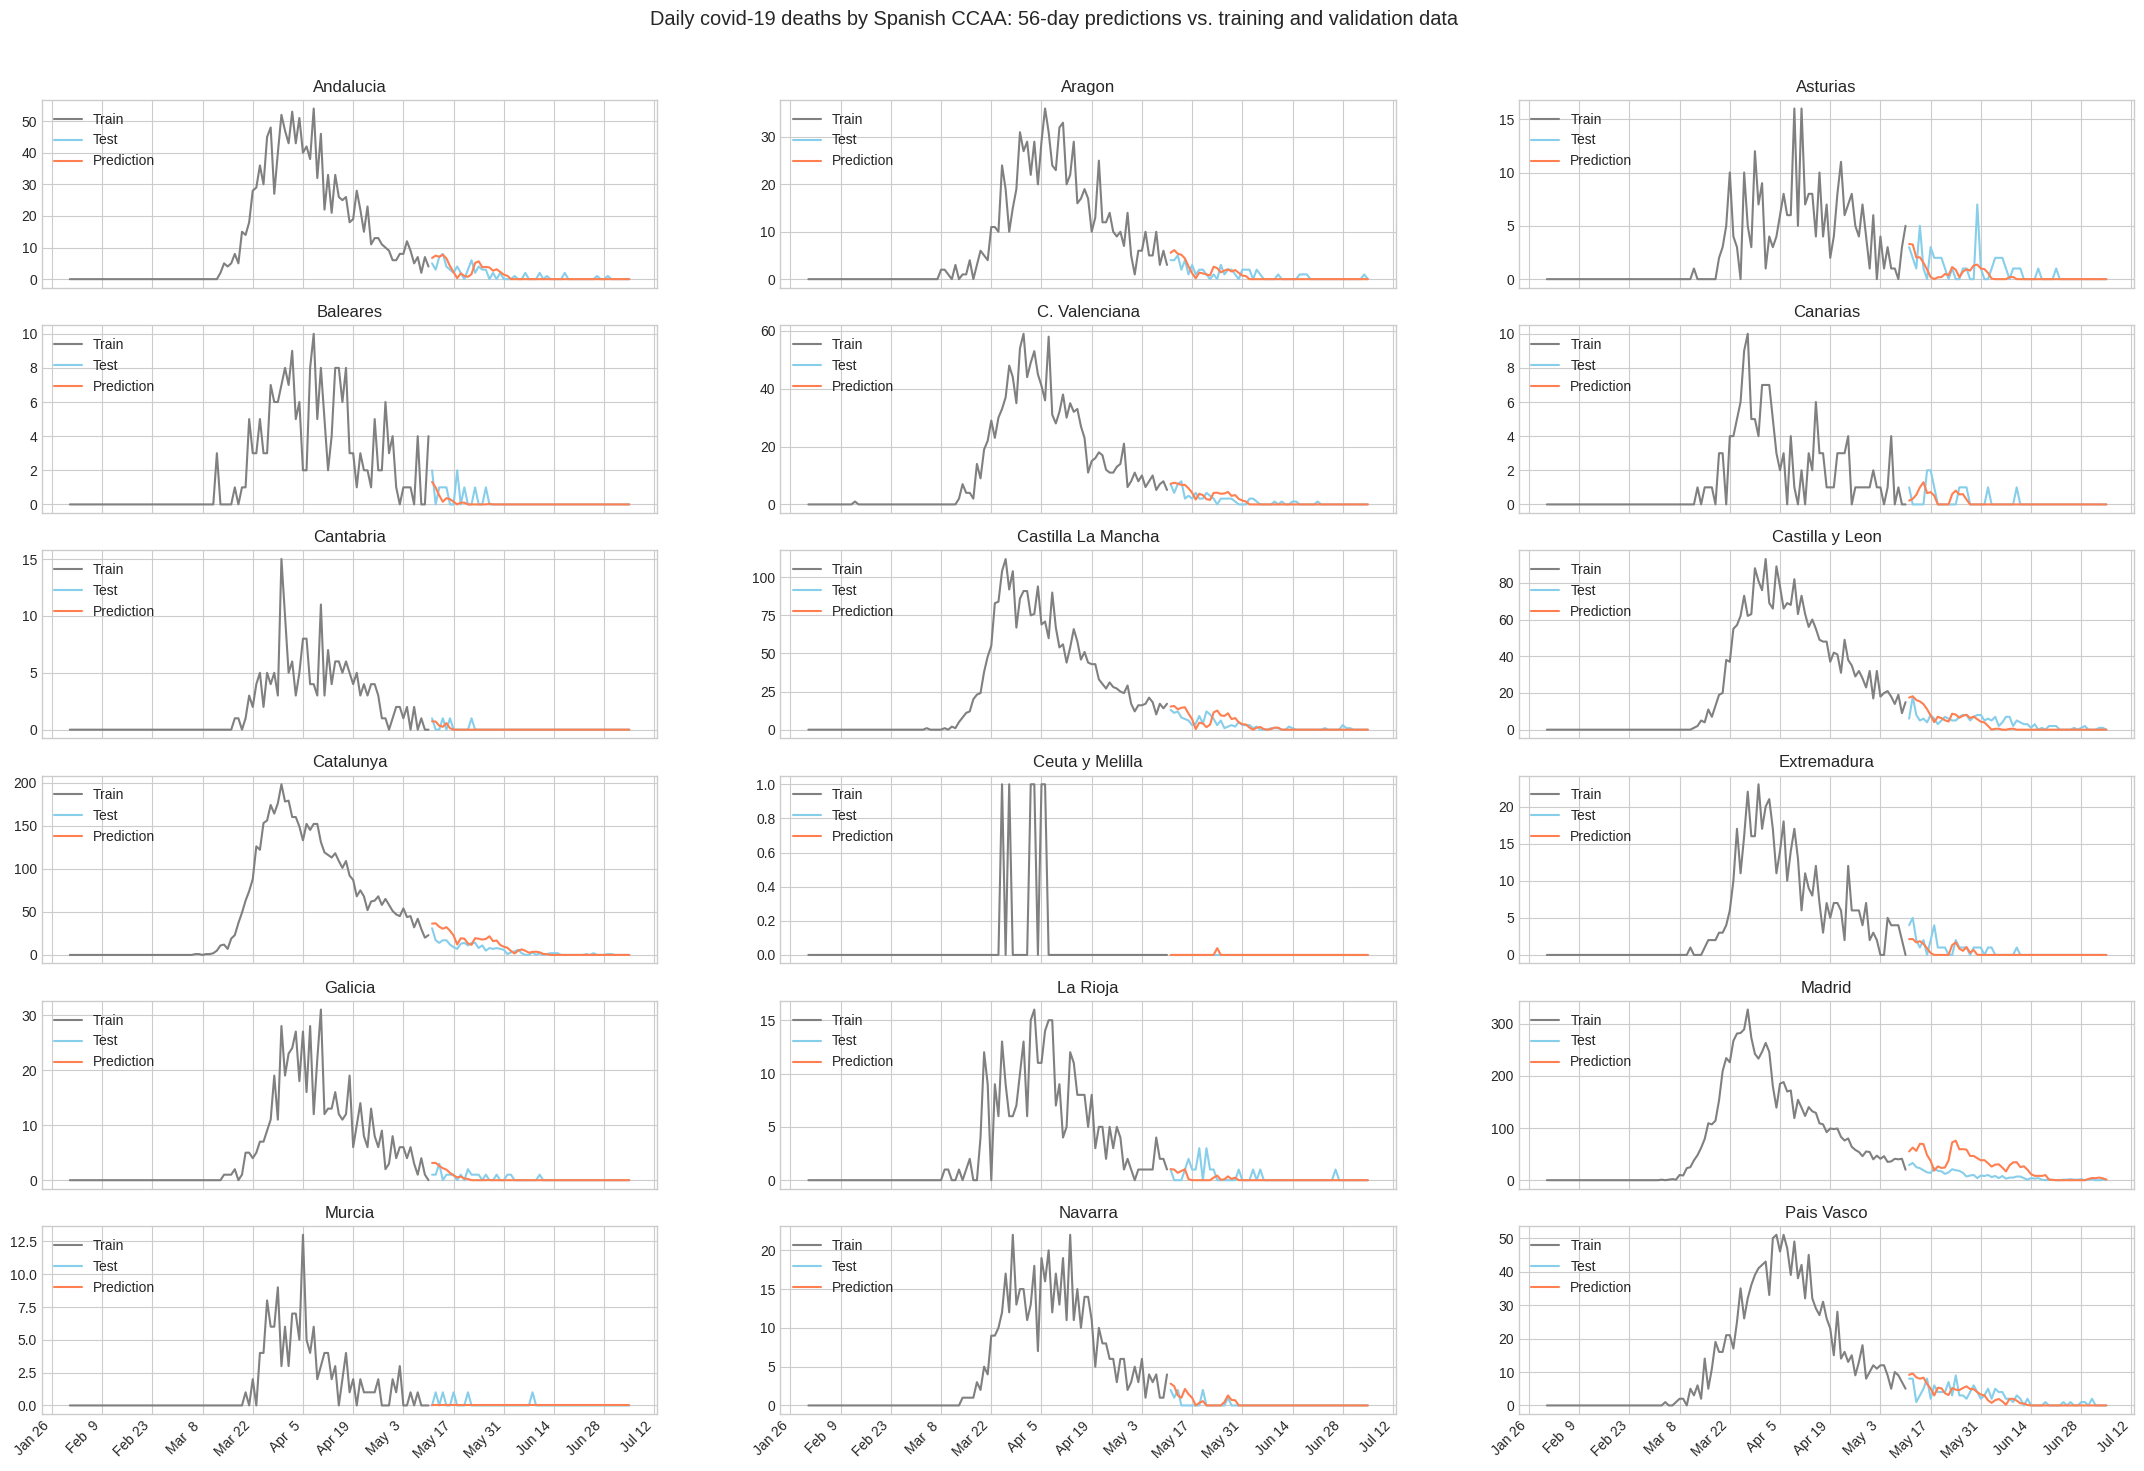

In [34]:
fig, ax = plt.subplots(6,3, figsize=(27,18))
fig.subplots_adjust(top=0.93)
i = 0
j = 0
for x in names_CCAA:
  ax[i,j].set_title(x, fontsize='large')
  ax[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax[i,j].xaxis.set_major_locator(plt.MultipleLocator(14))
  ax[i,j].plot(df_deaths_train.index, df_deaths_train[x], linewidth=1.5,color='gray', label='Train')
  ax[i,j].plot(df_deaths_test.index, df_deaths_test[x], linewidth=1.5, color='skyblue', label='Test')
  ax[i,j].plot(df_deaths_test.index, df_deaths_test[x + '_PREDICTED'], linewidth=1.5, color='coral', label='Prediction')
  ax[i,j].legend(loc='upper left', fontsize='medium')
  if j < 2:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig.suptitle('Daily covid-19 deaths by Spanish CCAA: ' + str(NBR_PREDICTIONS) + '-day predictions vs. training and validation data', fontsize='x-large')  
fig.autofmt_xdate(rotation=45, ha='right')
plt.show()

(End of Notebook)